# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

**1.1.  Loggi**

A [Loggi](https://www.loggi.com/) é uma startup unicórnio brasileira de tecnologia focada em **logística**. A Loggi começou entregando apenas documentos entre 2013 e 2014. Dois anos depois, entrou no segmento de e-commerce. E, desde 2017, tem atuado nas entregas de alimentos também.

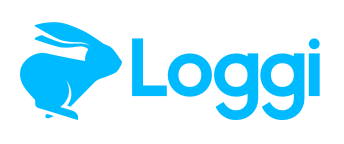


**1.2.  Loggi BUD**

O Loggi Benchmark for Urban Deliveries (BUD) é um repositório do GitHub ([link](https://github.com/loggi/loggibud)) com dados e códigos para problemas típicos que empresas de logística enfrentam: otimização das rotas de entrega, alocação de entregas nos veículos da frota com capacidade limitada, etc. Os dados são sintetizados de fontes públicas (IBGE, IPEA, etc.) e são representativos dos desafios que a startup enfrenta no dia a dia, especialmente com relação a sua escala.


## 2\. Pacotes e bibliotecas

In [1]:
import json
import numpy as np
import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
!pip install xlrd


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 1.0 MB/s eta 0:00:00


## 3\. Exploração de dados

**3.1.  Estrutura dos dados**

**Dados utilizados**

In [3]:
#todos os dados usados
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
!wget -q "https://raw.githubusercontent.com/lucas-furlanette/ebac-dados/main/projetos/deliveries-geodata.csv" -O deliveries-geodata.csv
!wget -q "https://raw.githubusercontent.com/lucas-furlanette/ebac-dados/main/projetos/distrito-federal.shp" -O distrito-federal.shp
!wget -q "https://raw.githubusercontent.com/lucas-furlanette/ebac-dados/main/projetos/distrito-federal.shx" -O distrito-federal.shx
!wget -q "https://raw.githubusercontent.com/lucas-furlanette/ebac-dados/main/projetos/DF.xls" -O DF.xls

> **Atenção**: Vamos trabalhar com um sub conjunto dos dados originais presentes neste [link](https://github.com/loggi/loggibud/blob/master/docs/quickstart.md). Em especial, as instâncias de treino de `cvrp` da cidade de Brasília.

O dado bruto é um arquivo do tipo `JSON` com uma lista de instâncias de entregas [link](https://github.com/andre-marcos-perez/ebac-course-utils/blob/main/dataset/deliveries.json). Cada instância representa um conjunto de **entregas** que devem ser realizadas pelos **veículos** do **hub** regional. Exemplo:


```json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...


Onde:

 - **name**: nome único da instância;
 - **region**: nome único da região do **hub**;
 - **origin**: latitude e longitude da região do **hub**;
 - **vehicle_capacity**: soma da capacidade de carga dos **veículos** do **hub**;
 - **deliveries**: **entregas** que devem ser realizadas.
 

Sendo que:

 - **id**: id único da **entrega**;
 - **point**: latitude e longitude da **entrega**;
 - **size**: tamanho ou a carga que a **entrega** ocupa no **veículo**.

**3.2 Wrangling**

In [4]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

deliveries_df = pd.DataFrame(data)

deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Tratamento da coluna origin, transformadas em duas novas colunas(hub_lng e hub_lat).

In [5]:
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Tratamento da coluna deliveries, transformadas em três novas colunas(delivery_size, delivery_lng e delivery_lat).

In [6]:
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


Verificando schema

In [7]:
deliveries_df.dtypes

name                 object
region               object
hub_lng             float64
hub_lat             float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

In [8]:
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [9]:
deliveries_df.select_dtypes("int64").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


## 4\. Manipulação

**4.1 Enriquecimento**

Aplicando a geocodificação nas coordenadas dos hub's para extrair informações de cidade e bairro.

In [10]:
geolocator = Nominatim(user_agent="ebac_geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

#enviando coord hubs
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)

#trabalhando retorno
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

#reagrupando as colunas no df principal
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", 
                               "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


Enquanto o **hub** contem apenas **3** geolocalizações distintas, as **entregas** somam o total de **636.149**, o que levaria em torno de 7 dias para serem consultadas no servidor do Nominatim, dada a restrição de uma consulta por segundo, por isso já iremos usar os dados prontos.

In [11]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Atribuindo dados gerais do DF disponibilizados pelo Codeplan [link](https://www.codeplan.df.gov.br/). A companhia de Planejamento do Distrito Federal (Codeplan) é uma empresa estatal brasileira do Distrito Federal que busca gerar conhecimento e inovação para aprimorar as políticas públicas do Governo do Distrito Federal e melhorar as condições de vida da população.

In [12]:
df_df = pd.read_excel('DF.xls', '1.1. Dados gerais, por RA')
df_df = df_df.dropna()
df_df.rename({'Dados gerais, por região administrativa - Distrito Federal - 2021': 'delivery_city', 'Unnamed: 3': 'populacao_total', 'Unnamed: 8': 'renda_domiciliar_per'}, axis=1, inplace=True)
df_df = df_df[['delivery_city', 'populacao_total', 'renda_domiciliar_per']]
df_df[['populacao_total', 'renda_domiciliar_per']] = df_df[['populacao_total', 'renda_domiciliar_per']].apply(pd.to_numeric)
df_df.reset_index(inplace=True, drop=True)
df= pd.merge(deliveries_df, df_df, how='left', on='delivery_city')
df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,populacao_total,renda_domiciliar_per
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,350347.0,1727.537565
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,350347.0,1727.537565
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,350347.0,1727.537565
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,350347.0,1727.537565
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,93217.0,915.515516


**4.2 Controle de qualidade**

In [13]:
df.select_dtypes("float64").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949902,0.091875,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,0.053463,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
delivery_lng,636149.0,-47.946087,0.112769,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,0.082462,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355
populacao_total,481664.0,125262.189381,91439.912201,1737.000000,55366.000000,120107.000000,186498.000000,350347.000000
renda_domiciliar_per,481664.0,4025.860031,2814.819855,695.372976,1772.873565,2619.294968,6003.780127,10979.134888


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   name                  636149 non-null  object 
 1   region                636149 non-null  object 
 2   hub_lng               636149 non-null  float64
 3   hub_lat               636149 non-null  float64
 4   hub_city              636149 non-null  object 
 5   hub_suburb            636149 non-null  object 
 6   vehicle_capacity      636149 non-null  int64  
 7   delivery_size         636149 non-null  int64  
 8   delivery_lng          636149 non-null  float64
 9   delivery_lat          636149 non-null  float64
 10  delivery_city         634447 non-null  object 
 11  delivery_suburb       476264 non-null  object 
 12  populacao_total       481664 non-null  float64
 13  renda_domiciliar_per  481664 non-null  float64
dtypes: float64(6), int64(2), object(6)
memory usage: 72.

In [15]:
df.isna().any()

name                    False
region                  False
hub_lng                 False
hub_lat                 False
hub_city                False
hub_suburb              False
vehicle_capacity        False
delivery_size           False
delivery_lng            False
delivery_lat            False
delivery_city            True
delivery_suburb          True
populacao_total          True
renda_domiciliar_per     True
dtype: bool

In [16]:
100 * (df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [17]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

In [18]:
jj = deliveries_df.query('delivery_city == "Brasília"')
pd.DataFrame(jj[['region', 'delivery_city']].value_counts(normalize=True)).reset_index()

,region,delivery_city,0
0,df-2,Brasília,0.466134
1,df-1,Brasília,0.437902
2,df-0,Brasília,0.095964


Os dados consebidos pela geocodificação são faltantes e imprecisos. Como exemplo é possível notar o valor incoerente de 'Brasilia" muitas vezes no "delivery_city/suburb".

## 5\. Visualização

**5.1 Mapa de entregas do Distrito Federal**

Vamos utilizar o pacote Python GeoPandas ([link](https://geopandas.org/) da documentação) para visualizar as coordenadas dos **hubs** e das **entregas** no mapa do Distrito Federal, segmentados pela região dos **hubs.**

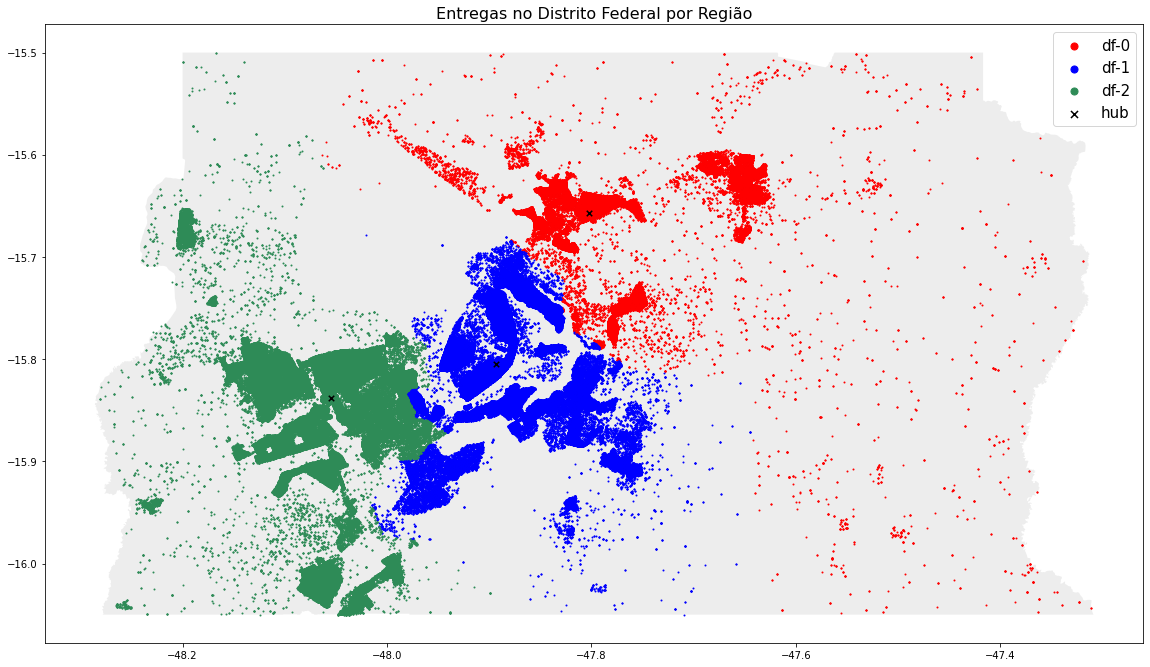

In [19]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]

#mapahubs
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))

#mapaentregas
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))

# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

<ul><li>A distribuição de entregas estão coerentes com seus respectivos hubs.</li> <li> Na df-1 pode se notar que há concentração maior proxima ao hub, abrangendo uma área menor que as outras duas.</li> <li> Há uma região quase sem entregas, deduzindo-se que é uma região de dificil acesso ou pouca civilização.</li></ul>

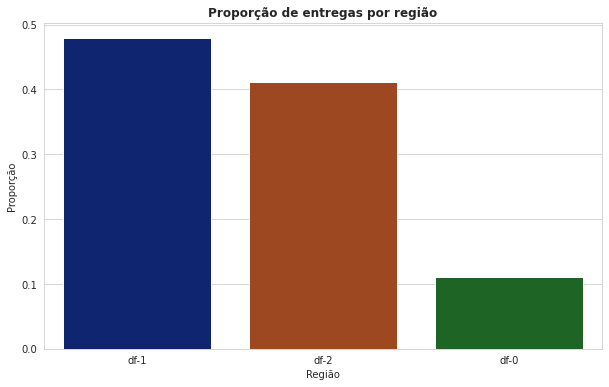

In [20]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="dark")
  grafico.set(xlabel='Região', ylabel='Proporção')
  grafico.set_title('Proporção de entregas por região', fontweight='bold')
  grafico.figure.set_size_inches(10,6)

<ul><li>A distribuição das entregas está muito concentrada nos hubs das regiões 1 e 2, mas pouco no da região 0.</li> <li>A capacidade dos veículos é mesma para todos os hubs, logo os veículos poderiam ser deslocados para as regiões de maior tráfego.</li></ul>

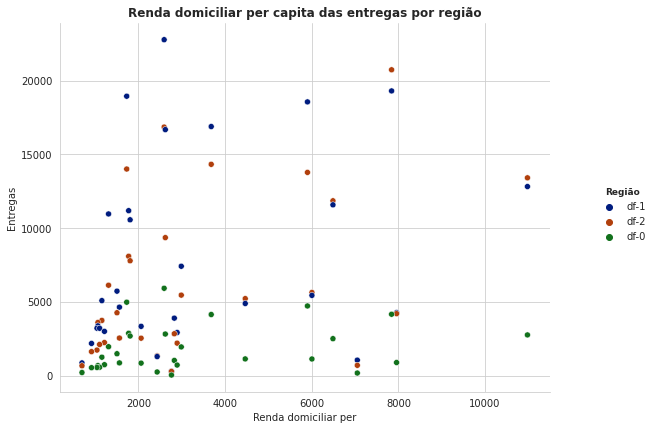

In [21]:
data2 = pd.DataFrame(df[['region', 'renda_domiciliar_per']].value_counts()).reset_index()

data2.rename(columns={0: "delivery_count"}, inplace=True)

with sns.axes_style('whitegrid'):
  grafico = sns.relplot(data=data2, x="renda_domiciliar_per", y="delivery_count", hue='region', ci=None, palette="dark")
  grafico.set(xlabel='Renda domiciliar per', ylabel='Entregas')
  grafico.ax.set_title('Renda domiciliar per capita das entregas por região', fontsize=12, fontweight='bold')
  grafico.legend.set_title('Região', prop={'size': 9, 'weight': 'bold'})
  grafico.fig.set_size_inches(10,6)

<li>Grande parte dos dados faltantes de renda são da região 1 e 2 e mesmo assim elas mostram possuir maior renda, indicando possuir um socioeconômico melhor.</li>

## 6\. Conclusão

Podemos ver que a Loggi atua em boa parte do Distrito Federal com hubs bem posicionados, notamos também que grande parte das entregas estão concentradas entre o centro e sul, onde possivelmente há uma  correlação entre o socioeconômico da região. Contra partida a região norte aparenta ser maior geograficamente e com muita dispersão nas entregas, podendo gerar  custos maiores e depreciação dos veículos. Nos gráficos acima chegamos a conclusão que seria interessante uma possível realocação de capacidade de veículos para regiões com maior tráfego, assim os aproveitando melhor.